<a href="https://colab.research.google.com/github/coy17a/2020DUCdatathon/blob/master/Final_Presentation_for_Identification_of_DUC_Wells.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Three (3) datasets (**Wellheader, Production** and **PerfTreatment**) were provided for wells in Alberta, British Columbia and saskatchewan. The purpose of this Untapped Energy Datathon exercise is to **identify the DUC wells** and **provide insights**.

Key Assumptions made to identify DUC wells are as follows: 

> A well with a Current Status of '**Flowing**', '**Gas Lift**', '**Pumping**' is not a DUC well.

> A well with **production volumes** recorded  is not a DUC well.

> A well with Completion Activities such as **Perforations**, **Well Stimulations** is not a DUC well.

As part of the insights, we are also assuming that all wells where DUC wells at some point. 

For the DUC wells, we will assume DUC status duration as the difference between **Rig Release Date** and the **Last Production Period** within the datasets provided. 

We will also determine how long the non-DUC wells had DUC status by assuming that as the difference between **Rig Release Date** and **First Production Date** or Last **Activity Date** whichever is greater. 

For exploratory Data Analysis please review separate Jupyter notebook 'EDA for Identification of DUC Wells' and corresponding html files. 


## Import required Python Libraries

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from google.colab import files


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Load datasets

In [ ]:
uploaded = files.upload()

Saving WellHeader_Datathon.csv to WellHeader_Datathon.csv


In [ ]:
uploaded_1 = files.upload()

Saving PerfTreatments.csv to PerfTreatments.csv


In [ ]:
uploaded_2 = files.upload()

Saving WellProduction.csv to WellProduction.csv


In [ ]:
import io
## list date columns to parse dates for wellheader dataset
datecolumns = ['LicenceDate', 'ConfidentialReleaseDate','AbandonDate', 'SurfAbandonDate', 'SpudDate', 'FinalDrillDate', 'RigReleaseDate','StatusDate','CompletionDate']  

# load datasets
wellheader = pd.read_csv(io.StringIO(uploaded['WellHeader_Datathon.csv'].decode("utf-8")),parse_dates=datecolumns, low_memory=False, na_values='Not Applicable')
perftreatment = pd.read_csv(io.StringIO(uploaded_1['PerfTreatments.csv'].decode("utf-8")),parse_dates=['ActivityDate'])
wellproduction = pd.read_csv(io.StringIO(uploaded_2['WellProduction.csv'].decode("utf-8")), parse_dates=['ProdPeriod'])


In [ ]:
wellheader = wellheader.iloc[:,0:85]
wellproduction=wellproduction.iloc[:,0:4]
perftreatment=perftreatment.iloc[:,0:8]

## Convert datatypes

In [ ]:
## Select objects to convert to category type for wellheader data
obj_cast_category = ['Province', 'CurrentOperator', 'CurrentOperatorParentName',
       'Licensee', 'LicenseeParentCompanyName', 'CurrentStatus',
       'CurrentStatusStandardised', 'WellType', 'WellTypeStandardised',
       'Formation', 'Field', 'Pool', 'SurveySystem',
       'Surf_Meridian', 
       'Surf_QuarterUnit',  'Surf_Block', 'Surf_NTSMapSheet',
       'Surf_Area',  'Surf_QuarterSection',
       'BH_Location', 'BH_QuarterUnit', 
       'BH_Block', 'BH_NTSMapSheet', 'BH_Area', 
       'BH_QuarterSection', 'BH_Meridian', 'LaheeClass', 'Confidential',
       'SurfaceOwner', 'OSArea', 'OSDeposit', 'DrillingContractor',
       'WellProfile', 'Country', 'RegulatoryAgency', 'PSACAreaCode',
       'PSACAreaName', 'StatusSource', 'UnitFlag','Municipality']       


wellheader[obj_cast_category] = wellheader[obj_cast_category].astype('category')

# change ProdType and ActivityType columns from object to category datatype
wellproduction['ProdType'] = wellproduction['ProdType'].astype('category')
perftreatment['ActivityType'] = perftreatment['ActivityType'].astype('category')

## Drop unnecessary Columns

In [ ]:
##create list of columns to be dropped

dropcols_wellheader= ['CompletionDate','UnitID', 'UnitFlag', 'UnitName', 'Confidential', 'RegulatoryAgency', 'ConfidentialReleaseDate', 'AbandonDate', 'SurfAbandonDate', 'OSArea', 'OSDeposit', 'Municipality']

print('well columns to drop as follows:' + ' ')
print(dropcols_wellheader)

well columns to drop as follows: 
['CompletionDate', 'UnitID', 'UnitFlag', 'UnitName', 'Confidential', 'RegulatoryAgency', 'ConfidentialReleaseDate', 'AbandonDate', 'SurfAbandonDate', 'OSArea', 'OSDeposit', 'Municipality']


In [ ]:
## drop columns selected
wellheader = wellheader.drop(columns=dropcols_wellheader, axis=1, inplace=False)

## Check number of rows and columns
wellheader.shape

(10437, 73)

## Add a Completion Activity Column to PerfTreatment Data

In [ ]:
## create perf activity type dictionary to classify as Completion Activity (Yes or No) based on our assumptions and intrepretation for the different perftreatment['ActivityType'].
perf_activity_dict = {'Perforation': 'Yes',
 'Fracture': 'Yes',
 'Hydraulic Fracture': 'Yes',
 'Sand Fracture': 'Yes',
 'Open Hole': 'No',
 'Chemical Fracture': 'Yes',
 'Other' : 'No',
 'Acid Squeeze' : 'Yes',
 'Bridge Plug Set' : 'No',
 'Acid Wash' : 'Yes',
 'Acidize' : 'Yes',
 'Remedial' : 'Yes',
 'Cement Squeeze' : 'Yes',
'Hydra Jet Perforation': 'Yes',
 'Slotted Liner' : 'Yes',
 'Open Hole/Barefoot Completion' : 'No',
 'Remedial Casing Cementing' : 'No',
 'Cement Plug' : 'Yes',
 'Multi-Stage Fracture - Port Closed': 'Yes',
 'Bridge Plug - No Cement' : 'No',
 'Packing Device Capped w/Cement' : 'Yes',
 'Chemical Squeeze': 'Yes',
 'Casing Patch' : 'No',
 'Acid Treatment' : 'Yes',
 'Multi-Stage Fracture': 'Yes'}

print(perf_activity_dict)

{'Perforation': 'Yes', 'Fracture': 'Yes', 'Hydraulic Fracture': 'Yes', 'Sand Fracture': 'Yes', 'Open Hole': 'No', 'Chemical Fracture': 'Yes', 'Other': 'No', 'Acid Squeeze': 'Yes', 'Bridge Plug Set': 'No', 'Acid Wash': 'Yes', 'Acidize': 'Yes', 'Remedial': 'Yes', 'Cement Squeeze': 'Yes', 'Hydra Jet Perforation': 'Yes', 'Slotted Liner': 'Yes', 'Open Hole/Barefoot Completion': 'No', 'Remedial Casing Cementing': 'No', 'Cement Plug': 'Yes', 'Multi-Stage Fracture - Port Closed': 'Yes', 'Bridge Plug - No Cement': 'No', 'Packing Device Capped w/Cement': 'Yes', 'Chemical Squeeze': 'Yes', 'Casing Patch': 'No', 'Acid Treatment': 'Yes', 'Multi-Stage Fracture': 'Yes'}


In [ ]:
# map dictionary to the existing perftreatment table
perftreatment['CompletionActivity'] = perftreatment['ActivityType'].map(perf_activity_dict)

In [ ]:
perftreatment['CompletionActivity'] = perftreatment['CompletionActivity'].astype('category')

perftreatment['CompletionActivity'].unique()

[Yes, No, NaN]
Categories (2, object): [Yes, No]

## Identify DUC Wells. 

1. Assume any Well that doesn't have status as ['Pumping', 'Flowing', 'Gas Lift'] could potentially be a DUC well. Create a subset of data of wells without this status as subset_wellheader. 
2. Filter out the wells from the subset_wellheader data that are not in the perftreatment or production datasets as DUCS.
3. Filter out any wells in the perftreatment data, that have no recorded production data as DUC_perf.
4. Identify if there are any potential DUCs based on perftreatment data only. 
5. If there are cross check with DUCS_perf (perftreatment wells with no production data). The assumption here is that some wells may have been completed but had no production volumes. 
6. Filter out wells that have identified to have no completion activities from DUCS_perf as DUCS_perf_final. 



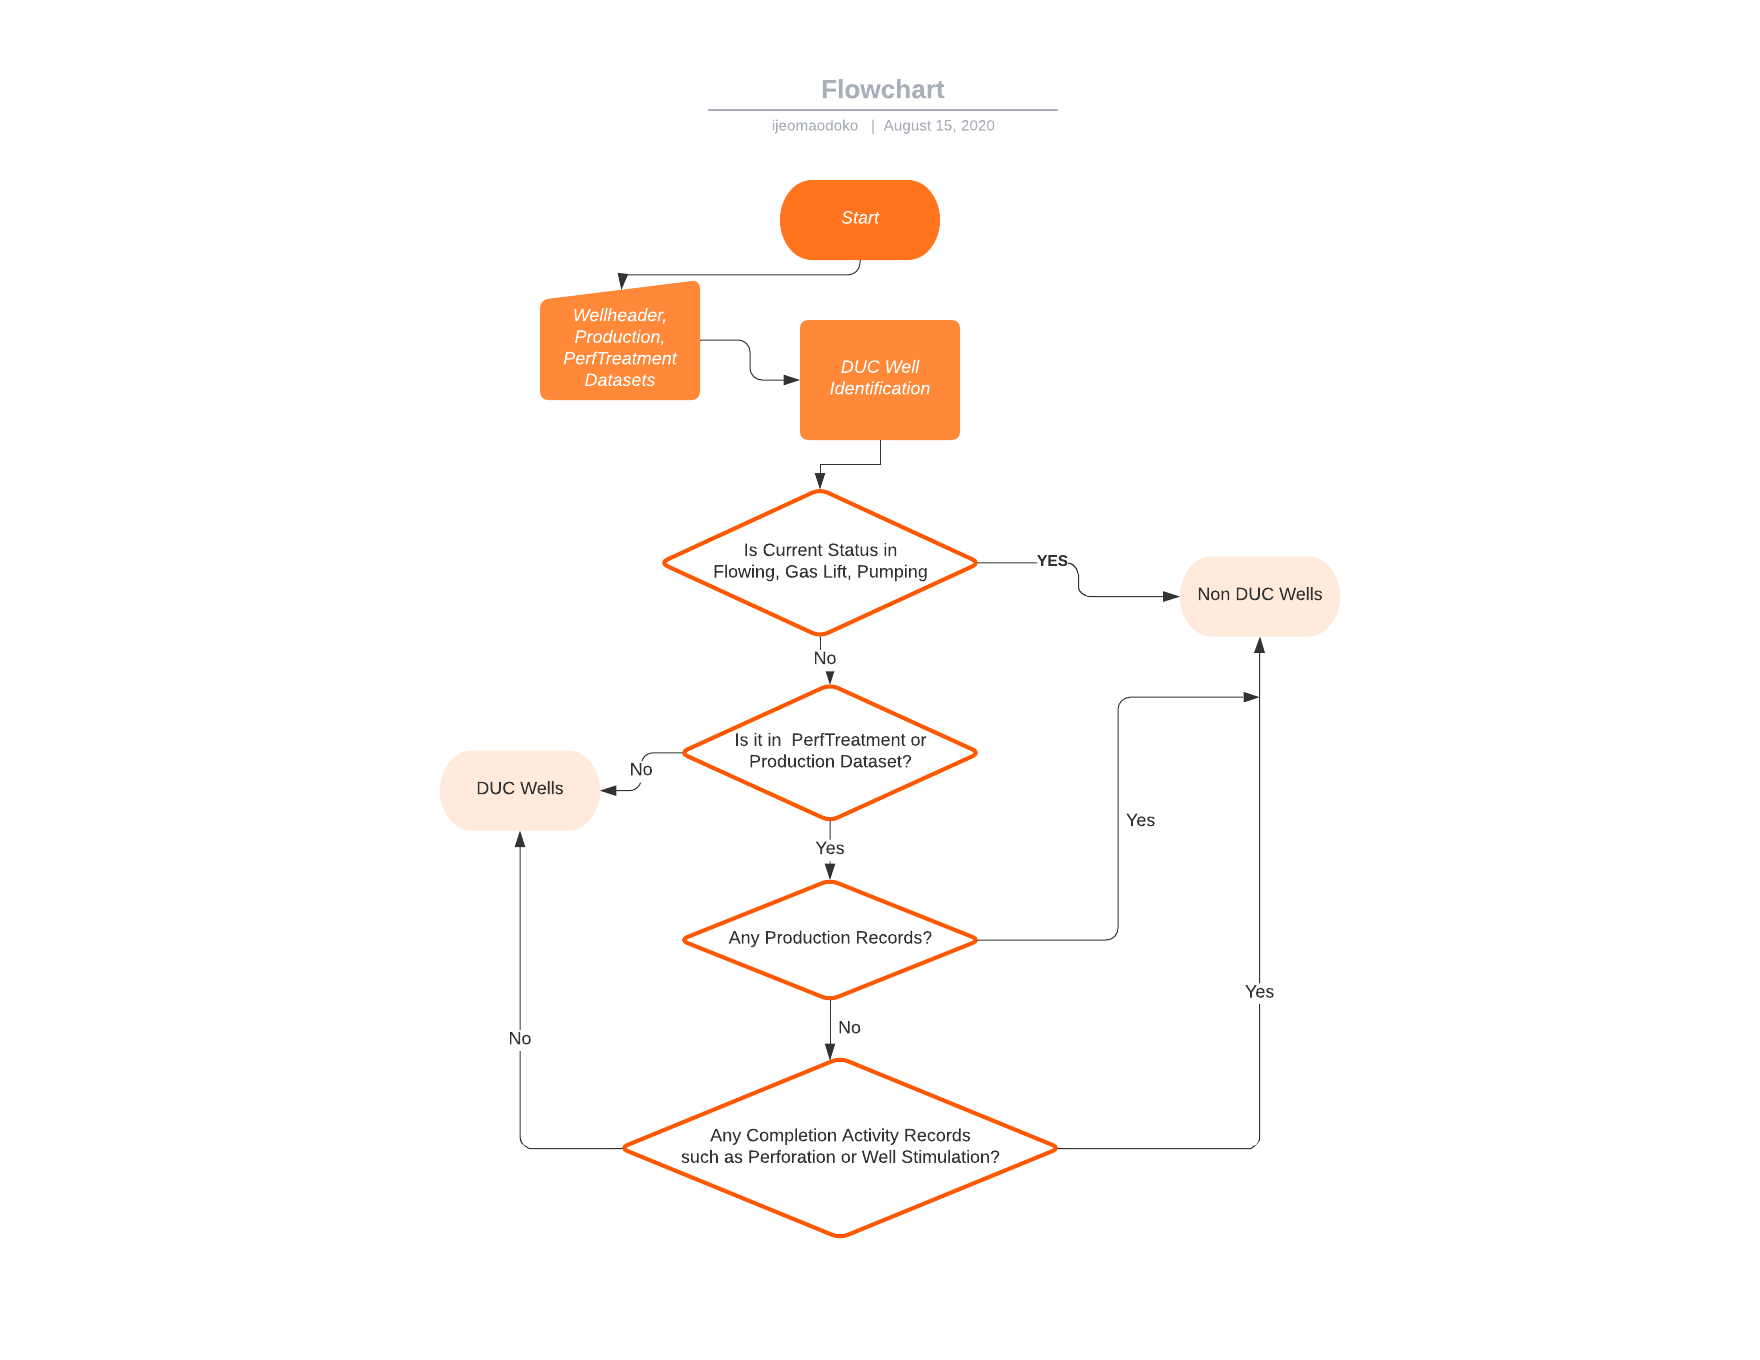


Step 1

In [ ]:
# filter out wells with Current Status that are not in ['Pumping', 'Flowing', 'Gas Lift']

subset_wellheader = wellheader[~wellheader['CurrentStatus'].isin(['Pumping', 'Flowing', 'Gas Lift'])]

# check only required variables for Current Status remain
subset_wellheader['CurrentStatus'].unique()


[Suspended, Active]
Categories (2, object): [Suspended, Active]

In [ ]:
# check number of wells remaining 
print('number of wells with Current Status not in ["Pumping", "Flowing", "Gas Lift"] ', subset_wellheader['EPAssetsId'].nunique())

number of wells with Current Status not in ["Pumping", "Flowing", "Gas Lift"]  5891


Step 2

In [ ]:
# filtering wells not in perf_treatment nor in well_production from subset_wellheader
DUCS = subset_wellheader[~subset_wellheader['EPAssetsId'].isin(perftreatment['EPAssetsId'])]
DUCS = DUCS[~DUCS['EPAssetsId'].isin(wellproduction['EPAssetsId'])]
print ('number of wells not in perf_treatment data nor in well_production data ', DUCS.shape[0])

number of wells not in perf_treatment data nor in well_production data  17


Step 3

In [ ]:
# filtering wells in perftreatment that have no production data
DUCS_perf = perftreatment[~perftreatment['EPAssetsId'].isin(wellproduction['EPAssetsId'])]
print('number of wells from perftreatment datatable that have no production data ', DUCS_perf['EPAssetsId'].nunique())

number of wells from perftreatment datatable that have no production data  21


Step 4

In [ ]:
## Create subsets of Perf Treatment to obtain wells which have Completion Activity as Yes, No or NaN
perftreatment_subset_columns = perftreatment[['EPAssetsId', 'CompletionActivity', 'ActivityDate']]

perftreatment_subset_null_values = perftreatment_subset_columns[pd.isnull(perftreatment_subset_columns['CompletionActivity'])]

perftreatment_subset2 = perftreatment_subset_columns[perftreatment_subset_columns['CompletionActivity'] !='Yes']

perftreatment_subset1 = perftreatment_subset_columns[perftreatment_subset_columns['CompletionActivity'] =='Yes']

print('number of wells in perftreatment data ', perftreatment_subset_columns['EPAssetsId'].nunique())

print('number of wells in perftreatment data with Completion Activity as "Yes" ', perftreatment_subset1['EPAssetsId'].nunique())

print('number of wells in perftreatment data with Completion Activity as "No" ', perftreatment_subset2['EPAssetsId'].nunique())

print('number of wells in perftreatment data with Completion Activity as "NaN" ', perftreatment_subset_null_values['EPAssetsId'].nunique())

number of wells in perftreatment data  10108
number of wells in perftreatment data with Completion Activity as "Yes"  9906
number of wells in perftreatment data with Completion Activity as "No"  2129
number of wells in perftreatment data with Completion Activity as "NaN"  46


In [ ]:
# calculate number of wells with Completion Activity with only No or NaN

if perftreatment_subset_columns['EPAssetsId'].nunique() > perftreatment_subset1['EPAssetsId'].nunique():
    Potential_DUC_wells = perftreatment_subset_columns['EPAssetsId'].nunique() - perftreatment_subset1['EPAssetsId'].nunique()
    print('Potential number of DUC wells using only the CompletionActivity criteria from perftreatment table = ', Potential_DUC_wells)
else: 
    print('No wells identified as potential DUC wells using only CompletionActivity criteria from perftreatment table')

Potential number of DUC wells using only the CompletionActivity criteria from perftreatment table =  202


Step 5 and 6

In [ ]:
# check to see if there are any wells with no production that have also not been completed
DUCS_perf_final= DUCS_perf[~DUCS_perf['EPAssetsId'].isin(perftreatment_subset1['EPAssetsId'])]

DUCS_perf_final

,EPAssetsId,EPAPTId,ObservationNumber,ActivityDate,ActivityType,IntervalTop,IntervalBase,PerfShots,CompletionActivity
276538,40817,216191,NaN,2019-11-04,Open Hole,1677.0,4256.0,NaN,No


## Append DUC well lists to get complete final list

In [ ]:
Final_DUC_List = DUCS['EPAssetsId'].append(DUCS_perf_final['EPAssetsId'].drop_duplicates(), ignore_index=True)

Final_DUC_List.shape

(18,)

## Determine the Formation or PSACAreaName of the DUC wells identified. 

In [ ]:
# merge Final DUC list with wellheader data to get full wellheader information

DUCS_dataframe = wellheader[wellheader['EPAssetsId'].isin(Final_DUC_List)]

In [ ]:
# Where the DUCS identified located 

print ('The DUCS are located in the following Formation: ', DUCS_dataframe['Formation'].unique())
print('\n')
print('The DUCS are located in the following PSACAreaName: ', DUCS_dataframe['PSACAreaName'].unique())
print('\n')
print('The DUCS are located in the following Fields: ', DUCS_dataframe['Field'].unique())


The DUCS are located in the following Formation:  [Montney]
Categories (1, object): [Montney]


The DUCS are located in the following PSACAreaName:  [Northern British Columbia]
Categories (1, object): [Northern British Columbia]


The DUCS are located in the following Fields:  [Inga, Northern Montney, Heritage]
Categories (3, object): [Inga, Northern Montney, Heritage]


## What is the Regulatory Status of these DUC wells identified. 

In [ ]:
print ('The Current Regulatory Status of these DUC wells: ', DUCS_dataframe['CurrentStatus'].unique())


The Current Regulatory Status of these DUC wells:  [Active]
Categories (1, object): [Active]


## Determine how long the DUC wells have gone Uncompleted

In [ ]:
# get max production period from production dataframe

Latest_production_period = wellproduction['ProdPeriod'].max()

print ('The latest production period is ', Latest_production_period)

The latest production period is  2020-01-31 00:00:00


In [ ]:
# merge Final DUC list with wellheader data to get full wellheader information

DUCS_dataframe = wellheader[wellheader['EPAssetsId'].isin(Final_DUC_List)]

# create new column for how long well has been a DUC
DUCS_final_dataframe = DUCS_dataframe.copy()
DUCS_final_dataframe.loc[:,'Days of Uncompleted Status'] = Latest_production_period - DUCS_final_dataframe['RigReleaseDate']

# transform days to numeric datatype
DUCS_final_dataframe.loc[:,'Days of Uncompleted Status'] = DUCS_final_dataframe['Days of Uncompleted Status']/np.timedelta64(1, 'D')

In [ ]:
#check statistics of 'Days of Uncompleted Status'
DUCS_final_dataframe ['Days of Uncompleted Status'].describe()

count     18.000000
mean     199.611111
std      107.379557
min       71.000000
25%      123.500000
50%      192.000000
75%      213.750000
max      420.000000
Name: Days of Uncompleted Status, dtype: float64

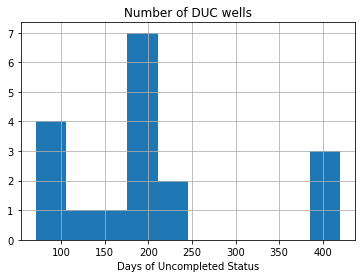

In [ ]:
#create histogram of 'Days of Uncompleted Status'
DUCS_final_dataframe ['Days of Uncompleted Status'].hist()
plt.xlabel('Days of Uncompleted Status')
plt.title('Number of DUC wells')
plt.show()


## Create Bins for Days of Uncompleted Status

In [ ]:
# create bins for range of days of uncompleted status
bins = [0, 60, 90, 365, 730, 1095]
labels = ['<60days', '60-90days', '90-365days', '365-730days', '730-1095days']
DUCS_final_dataframe['Binned'] = pd.cut(DUCS_final_dataframe['Days of Uncompleted Status'], bins=bins, labels=labels)
DUCS_final_dataframe.head(5)

,EPAssetsId,Province,LicenceNumber,UWI,CurrentOperator,CurrentOperatorParent,CurrentOperatorParentName,Licensee,LicenseeParentCompany,LicenseeParentCompanyName,LicenceDate,CurrentStatus,CurrentStatusStandardised,WellType,WellTypeStandardised,WellName,Formation,Field,Pool,SurveySystem,Surf_Location,Surf_Township,Surf_Meridian,Surf_Range,Surf_Section,Surf_LSD,Surf_Longitude,Surf_Latitude,Surf_TownshipRange,Surf_QuarterUnit,Surf_Unit,Surf_Block,Surf_NTSMapSheet,Surf_Series,Surf_Area,Surf_Sheet,Surf_QuarterSection,BH_Location,BH_TownshipRange,BH_QuarterUnit,BH_Unit,BH_Block,BH_NTSMapSheet,BH_Series,BH_Area,BH_Sheet,BH_QuarterSection,BH_Longitude,BH_Latitude,BH_Township,BH_Meridian,BH_Range,BH_Section,BH_LSD,GroundElevation,KBElevation,TotalDepth,LaheeClass,SurfaceOwner,DrillingContractor,SpudDate,FinalDrillDate,RigReleaseDate,DaysDrilling,DrillMetresPerDay,TVD,WellProfile,Country,PSACAreaCode,PSACAreaName,ProjectedDepth,StatusDate,StatusSource,Days of Uncompleted Status,Binned
7787,43463,British Columbia,37176,103131608823W600,Kelt Exploration (Lng) Ltd.,4007,Kelt Exploration Ltd.,Kelt Exploration (Lng) Ltd.,4007,Kelt Exploration Ltd.,2019-01-18,Active,Active,Gas Production,Gas,Kelt Lng Hz Inga A04-09-088-23,Montney,Inga,Montney A,DLS,04-09-088-23-W6,88.0,W6,23.0,9.0,4.0,-121.612986,56.611944,088-23-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,13-16-088-23-W6,088-23-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,W6,23.0,16.0,13.0,890.5,897.1,5048.0,Development,Unspecified,Horizon 55,2019-02-26,NaT,2019-11-20,267.0,18.906367,NaN,Horizontal,Canada,BC2,Northern British Columbia,4780.0,2020-01-30,BCOGC,72.0,60-90days
7798,43469,British Columbia,37184,105161708823W600,Kelt Exploration (Lng) Ltd.,4007,Kelt Exploration Ltd.,Kelt Exploration (Lng) Ltd.,4007,Kelt Exploration Ltd.,2019-01-18,Active,Active,Gas Production,Gas,Kelt Lng Hz Inga E04-09-088-23,Montney,Northern Montney,Montney A,DLS,04-09-088-23-W6,88.0,W6,23.0,9.0,4.0,-121.613764,56.611914,088-23-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,16-17-088-23-W6,088-23-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88.0,W6,23.0,17.0,16.0,890.5,897.0,4955.0,Development,Unspecified,Horizon 55,2019-02-21,NaT,2019-10-16,237.0,20.907173,NaN,Horizontal,Canada,BC2,Northern British Columbia,4915.0,2020-01-30,BCOGC,107.0,90-365days
8179,42139,British Columbia,34828,103043308015W600,Tourmaline Oil Corp.,1312,Tourmaline Oil Corp.,Tourmaline Oil Corp.,1312,Tourmaline Oil Corp.,2017-10-05,Active,Active,Gas Production,Gas,Tourmaline Hz Doe B03-34-080-15,Montney,Heritage,Montney A,DLS,03-34-080-15-W6,80.0,W6,15.0,34.0,3.0,-120.263333,55.974111,080-15-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,04-33-080-15-W6,080-15-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,W6,15.0,33.0,4.0,661.0,667.0,3834.0,Development,Unspecified,Precision 538,2019-06-04,NaT,2019-07-22,48.0,79.875000,NaN,Horizontal,Canada,BC2,Northern British Columbia,4500.0,2020-01-31,BCOGC,193.0,90-365days
8180,42138,British Columbia,34827,102043308015W600,Tourmaline Oil Corp.,1312,Tourmaline Oil Corp.,Tourmaline Oil Corp.,1312,Tourmaline Oil Corp.,2017-10-05,Active,Active,Gas Production,Gas,Tourmaline Hz Doe A03-34-080-15,Montney,Heritage,Montney A,DLS,03-34-080-15-W6,80.0,W6,15.0,34.0,3.0,-120.263331,55.974067,080-15-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,04-33-080-15-W6,080-15-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,W6,15.0,33.0,4.0,661.0,667.0,3890.0,Development,Unspecified,Precision 538,2019-06-05,NaT,2019-07-17,42.0,92.619048,NaN,Horizontal,Canada,BC2,Northern British Columbia,4500.0,2020-01-31,BCOGC,198.0,90-365days
8695,42723,British Columbia,35737,102041208015W600,Arc Resources Ltd.,16,ARC Resources Ltd.,Arc Resources Ltd.,16,ARC Resources Ltd.,2018-03-23,Active,Active,Gas Production,Gas,Arcres Hz Doe G12-31-079-14,Montney,Heritage,Montney A,DLS,12-31-079-14-W6,79.0,W6,14.0,31.0,12.0,-120.191047,55.892319,079-14-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NW,04-12-080-15-W6,080-15-W6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,80.0,W6,15.0,12.0,4.0,686.0,692.0,5004.0,Development

In [ ]:
# groupby number of wells by bin label
DUCS_dataframe_binned = DUCS_final_dataframe.groupby(by='Binned', as_index=False).agg({'EPAssetsId':'size'})
print(DUCS_dataframe_binned)

         Binned  EPAssetsId
0       <60days           0
1     60-90days           4
2    90-365days          11
3   365-730days           3
4  730-1095days           0


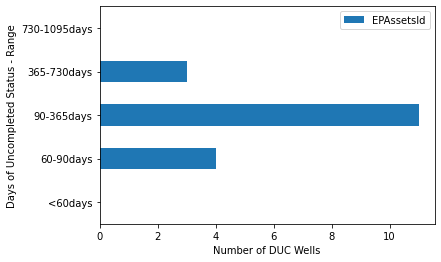

In [ ]:
# create bar graph

DUCS_dataframe_binned.plot.barh(x='Binned', y='EPAssetsId')
plt.xlabel('Number of DUC Wells')
plt.ylabel('Days of Uncompleted Status - Range')
plt.show()

## Derive some insights using the bins created 

In [ ]:
# groupby number of wells by PSACArea and bin labels
DUCS_dataframe_binned_Field= DUCS_final_dataframe.groupby(by=['Binned', 'Field'], as_index=False, observed=True).agg({'EPAssetsId': 'size'})
print(DUCS_dataframe_binned_Field)

        Binned             Field  EPAssetsId
0    60-90days              Inga           1
1    60-90days          Heritage           3
2   90-365days  Northern Montney           2
3   90-365days          Heritage           9
4  365-730days  Northern Montney           3


## DUC status duration for non-DUC wells

In [ ]:
## non DUC wells dataframe

non_DUCS_dataframe = wellheader[~wellheader['EPAssetsId'].isin(Final_DUC_List)]

non_DUCS_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10419 entries, 0 to 10436
Data columns (total 73 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   EPAssetsId                 10419 non-null  int64         
 1   Province                   10419 non-null  category      
 2   LicenceNumber              10419 non-null  object        
 3   UWI                        10419 non-null  object        
 4   CurrentOperator            10419 non-null  category      
 5   CurrentOperatorParent      10419 non-null  int64         
 6   CurrentOperatorParentName  10419 non-null  category      
 7   Licensee                   10419 non-null  category      
 8   LicenseeParentCompany      10419 non-null  int64         
 9   LicenseeParentCompanyName  10419 non-null  category      
 10  LicenceDate                10419 non-null  datetime64[ns]
 11  CurrentStatus              10419 non-null  category      
 12  Curr

In [ ]:
## groupby production data to remove duplicates, and calculate first production period per well

First_production_by_well = wellproduction.groupby(by='EPAssetsId', as_index=False, observed=True).agg({'ProdPeriod': 'min'})

First_production_by_well.head(5)

,EPAssetsId,ProdPeriod
0,3373,2017-08-31
1,6976,2015-11-30
2,6977,2015-11-30
3,7129,2017-06-30
4,7130,2017-06-30


In [ ]:
# groupby perforation data by EPAssetsId and Last Activity Date

Last_Activity_Date_by_well = perftreatment.groupby(by='EPAssetsId', as_index=False).agg({'ActivityDate': 'max'})

Last_Activity_Date_by_well.head()

,EPAssetsId,ActivityDate
0,3373,2017-07-29
1,6976,2015-10-30
2,6977,2015-10-31
3,7129,2017-11-25
4,7130,2017-11-26


In [ ]:
## merge non DUC wells dataframe['EPAssetsId', 'RigReleaseDate'] with production data and perftreatment data
non_DUCS_dataframe = non_DUCS_dataframe.merge(First_production_by_well, how='left', on='EPAssetsId')

non_DUCS_dataframe = non_DUCS_dataframe.merge(Last_Activity_Date_by_well, how='left', on='EPAssetsId')

non_DUCS_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10419 entries, 0 to 10418
Data columns (total 75 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   EPAssetsId                 10419 non-null  int64         
 1   Province                   10419 non-null  category      
 2   LicenceNumber              10419 non-null  object        
 3   UWI                        10419 non-null  object        
 4   CurrentOperator            10419 non-null  category      
 5   CurrentOperatorParent      10419 non-null  int64         
 6   CurrentOperatorParentName  10419 non-null  category      
 7   Licensee                   10419 non-null  category      
 8   LicenseeParentCompany      10419 non-null  int64         
 9   LicenseeParentCompanyName  10419 non-null  category      
 10  LicenceDate                10419 non-null  datetime64[ns]
 11  CurrentStatus              10419 non-null  category      
 12  Curr

In [ ]:
non_DUCS_dataframe.loc[:,'DUCStatusEndDate'] = non_DUCS_dataframe['ProdPeriod'].fillna(value=non_DUCS_dataframe['ActivityDate'])

non_DUCS_dataframe['DUCStatusEndDate'].isnull().sum()

13

#### Referencing the EDA for Identification of DUC wells, there are 30 wells not in the perftreatment data or production data, however when we use the well status value of Flowing, Pumping and Gas Lift, these 13 wells drop off, leaving us with 17 DUCS in our original first DUCS list. 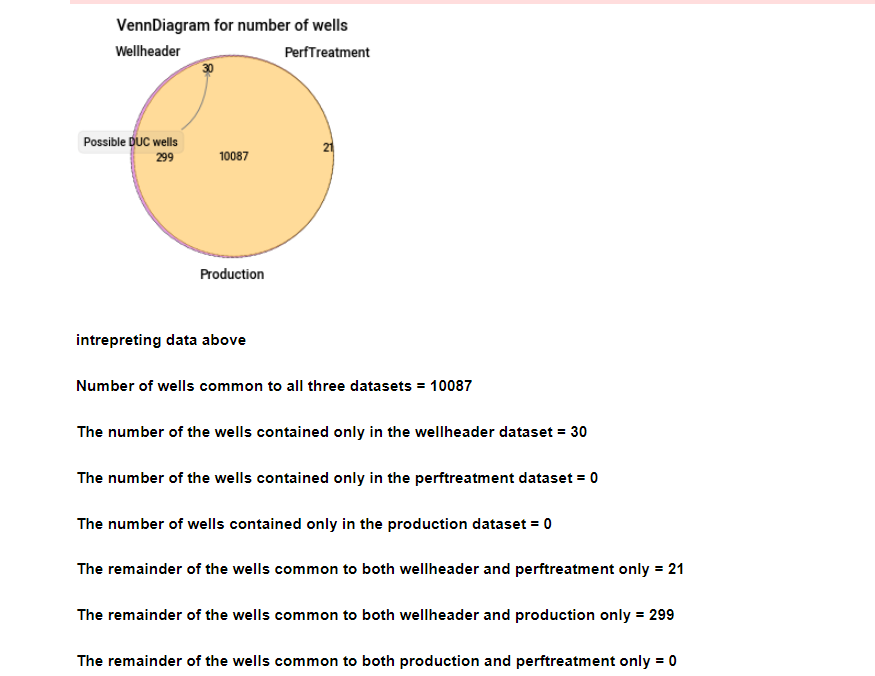

In [ ]:
## drop off rows that don't have Perftreatment or Production data
non_DUCS_dataframe.dropna(subset=['DUCStatusEndDate'], inplace = True)
non_DUCS_dataframe.shape


(10406, 76)

In [ ]:
non_DUCS_dataframe.head(2)

,EPAssetsId,Province,LicenceNumber,UWI,CurrentOperator,CurrentOperatorParent,CurrentOperatorParentName,Licensee,LicenseeParentCompany,LicenseeParentCompanyName,LicenceDate,CurrentStatus,CurrentStatusStandardised,WellType,WellTypeStandardised,WellName,Formation,Field,Pool,SurveySystem,Surf_Location,Surf_Township,Surf_Meridian,Surf_Range,Surf_Section,Surf_LSD,Surf_Longitude,Surf_Latitude,Surf_TownshipRange,Surf_QuarterUnit,Surf_Unit,Surf_Block,Surf_NTSMapSheet,Surf_Series,Surf_Area,Surf_Sheet,Surf_QuarterSection,BH_Location,BH_TownshipRange,BH_QuarterUnit,BH_Unit,BH_Block,BH_NTSMapSheet,BH_Series,BH_Area,BH_Sheet,BH_QuarterSection,BH_Longitude,BH_Latitude,BH_Township,BH_Meridian,BH_Range,BH_Section,BH_LSD,GroundElevation,KBElevation,TotalDepth,LaheeClass,SurfaceOwner,DrillingContractor,SpudDate,FinalDrillDate,RigReleaseDate,DaysDrilling,DrillMetresPerDay,TVD,WellProfile,Country,PSACAreaCode,PSACAreaName,ProjectedDepth,StatusDate,StatusSource,ProdPeriod,ActivityDate,DUCStatusEndDate
0,2587301,Alberta,475898,100122706624W500,Enerplus Corporation,267,Enerplus Corporation,Enerplus Corporation,267,Enerplus Corporation,2015-06-25,Gas Lift,Active,Crude Oil,Oil,ENERPLUS CORP HZ ANTEN 12-27-66-24,Montney,Ante Creek North,Commingled Pool 005,DLS,13-26-066-24-W5,66.0,W5,24.0,26.0,13.0,-117.529866,54.747632,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NW,12-27-066-24-W5,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NW,-117.553826,54.743675,66.0,W5,24.0,27.0,12.0,758.7,764.8,3677.0,Development,Crown,Excalibur Drilling Ltd,2015-12-05,2015-12-18,2015-12-21,13.0,282.85,NaN,Horizontal,Canada,AB2,Foothills Front,3800.0,2016-02-28,AER,2016-01-31,2015-12-28,2016-01-31
1,2593278,Alberta,479407,102052706624W500,Enerplus Corporation,267,Enerplus Corporation,Enerplus Corporation,267,Enerplus Corporation,2016-05-06,Gas Lift,Active,Crude Oil,Oil,ENERPLUS CORP 102HZ ANTEN 5-27-66-24,Montney,Ante Creek North,Commingled Pool 005,DLS,04-26-066-24-W5,66.0,W5,24.0,26.0,4.0,-117.527042,54.737446,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,05-27-066-24-W5,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,-117.553836,54.739474,66.0,W5,24.0,27.0,5.0,766.3,770.8,3607.0,Development,Crown,Excalibur Drilling Ltd,2016-05-26,2016-06-08,2016-06-10,13.0,277.46,1954.58,Horizontal,Canada,AB2,Foothills Front,3700.0,2016-09-23,AER,2016-07-31,2016-06-30,2016-07-31


In [ ]:
dataframe_check = non_DUCS_dataframe[non_DUCS_dataframe['DUCStatusEndDate'] <= non_DUCS_dataframe['RigReleaseDate']]

print(dataframe_check)

Empty DataFrame
Columns: [EPAssetsId, Province, LicenceNumber, UWI, CurrentOperator, CurrentOperatorParent, CurrentOperatorParentName, Licensee, LicenseeParentCompany, LicenseeParentCompanyName, LicenceDate, CurrentStatus, CurrentStatusStandardised, WellType, WellTypeStandardised, WellName, Formation, Field, Pool, SurveySystem, Surf_Location, Surf_Township, Surf_Meridian, Surf_Range, Surf_Section, Surf_LSD, Surf_Longitude, Surf_Latitude, Surf_TownshipRange, Surf_QuarterUnit, Surf_Unit, Surf_Block, Surf_NTSMapSheet, Surf_Series, Surf_Area, Surf_Sheet, Surf_QuarterSection, BH_Location, BH_TownshipRange, BH_QuarterUnit, BH_Unit, BH_Block, BH_NTSMapSheet, BH_Series, BH_Area, BH_Sheet, BH_QuarterSection, BH_Longitude, BH_Latitude, BH_Township, BH_Meridian, BH_Range, BH_Section, BH_LSD, GroundElevation, KBElevation, TotalDepth, LaheeClass, SurfaceOwner, DrillingContractor, SpudDate, FinalDrillDate, RigReleaseDate, DaysDrilling, DrillMetresPerDay, TVD, WellProfile, Country, PSACAreaCode, PSAC

In [ ]:
# create new column for DUC status duration
non_DUCS_final_dataframe = non_DUCS_dataframe.copy()
non_DUCS_final_dataframe.loc[:,'Days of Uncompleted Status'] = non_DUCS_dataframe['DUCStatusEndDate'] - non_DUCS_final_dataframe['RigReleaseDate']

# transform days to numeric datatype
non_DUCS_final_dataframe.loc[:,'Days of Uncompleted Status'] = non_DUCS_final_dataframe['Days of Uncompleted Status']/np.timedelta64(1, 'D')

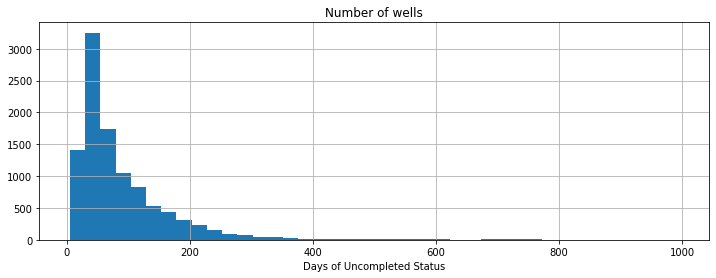

In [ ]:
# create histogram for DUC status duration for non_DUC_wells
non_DUCS_final_dataframe ['Days of Uncompleted Status'].hist(bins=40, figsize= (12, 4))
plt.xlabel('Days of Uncompleted Status')
plt.title('Number of wells')
plt.show()

## Create bins for Days of Uncompleted Status Duration 

In [ ]:
# create bins for range of days of uncompleted status
bins = [0, 60, 90, 365, 730, 1095]
labels = ['<60days', '60-90days', '90-365days', '365-730days', '730-1095days']
non_DUCS_final_dataframe['Binned'] = pd.cut(non_DUCS_final_dataframe['Days of Uncompleted Status'], bins=bins, labels=labels)
non_DUCS_final_dataframe.head(5)


,EPAssetsId,Province,LicenceNumber,UWI,CurrentOperator,CurrentOperatorParent,CurrentOperatorParentName,Licensee,LicenseeParentCompany,LicenseeParentCompanyName,LicenceDate,CurrentStatus,CurrentStatusStandardised,WellType,WellTypeStandardised,WellName,Formation,Field,Pool,SurveySystem,Surf_Location,Surf_Township,Surf_Meridian,Surf_Range,Surf_Section,Surf_LSD,Surf_Longitude,Surf_Latitude,Surf_TownshipRange,Surf_QuarterUnit,Surf_Unit,Surf_Block,Surf_NTSMapSheet,Surf_Series,Surf_Area,Surf_Sheet,Surf_QuarterSection,BH_Location,BH_TownshipRange,BH_QuarterUnit,BH_Unit,BH_Block,BH_NTSMapSheet,BH_Series,BH_Area,BH_Sheet,BH_QuarterSection,BH_Longitude,BH_Latitude,BH_Township,BH_Meridian,BH_Range,BH_Section,BH_LSD,GroundElevation,KBElevation,TotalDepth,LaheeClass,SurfaceOwner,DrillingContractor,SpudDate,FinalDrillDate,RigReleaseDate,DaysDrilling,DrillMetresPerDay,TVD,WellProfile,Country,PSACAreaCode,PSACAreaName,ProjectedDepth,StatusDate,StatusSource,ProdPeriod,ActivityDate,DUCStatusEndDate,Days of Uncompleted Status,Binned
0,2587301,Alberta,475898,100122706624W500,Enerplus Corporation,267,Enerplus Corporation,Enerplus Corporation,267,Enerplus Corporation,2015-06-25,Gas Lift,Active,Crude Oil,Oil,ENERPLUS CORP HZ ANTEN 12-27-66-24,Montney,Ante Creek North,Commingled Pool 005,DLS,13-26-066-24-W5,66.0,W5,24.0,26.0,13.0,-117.529866,54.747632,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NW,12-27-066-24-W5,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NW,-117.553826,54.743675,66.0,W5,24.0,27.0,12.0,758.7,764.8,3677.0,Development,Crown,Excalibur Drilling Ltd,2015-12-05,2015-12-18,2015-12-21,13.0,282.85,NaN,Horizontal,Canada,AB2,Foothills Front,3800.0,2016-02-28,AER,2016-01-31,2015-12-28,2016-01-31,41.0,<60days
1,2593278,Alberta,479407,102052706624W500,Enerplus Corporation,267,Enerplus Corporation,Enerplus Corporation,267,Enerplus Corporation,2016-05-06,Gas Lift,Active,Crude Oil,Oil,ENERPLUS CORP 102HZ ANTEN 5-27-66-24,Montney,Ante Creek North,Commingled Pool 005,DLS,04-26-066-24-W5,66.0,W5,24.0,26.0,4.0,-117.527042,54.737446,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,05-27-066-24-W5,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SW,-117.553836,54.739474,66.0,W5,24.0,27.0,5.0,766.3,770.8,3607.0,Development,Crown,Excalibur Drilling Ltd,2016-05-26,2016-06-08,2016-06-10,13.0,277.46,1954.58,Horizontal,Canada,AB2,Foothills Front,3700.0,2016-09-23,AER,2016-07-31,2016-06-30,2016-07-31,51.0,<60days
2,2579437,Alberta,469132,100162206624W500,Enerplus Corporation,267,Enerplus Corporation,Enerplus Corporation,267,Enerplus Corporation,2014-08-14,Gas Lift,Active,Crude Oil,Oil,ENERPLUS CORP HZ ANTEN 16-22-66-24,Montney,Ante Creek North,Commingled Pool 005,DLS,16-21-066-24-W5,66.0,W5,24.0,21.0,16.0,-117.559923,54.730864,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE,16-22-066-24-W5,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE,-117.534302,54.733247,66.0,W5,24.0,22.0,16.0,754.5,759.4,3502.0,Development,Crown,Excalibur Drilling Ltd,2015-01-06,2015-01-19,2015-01-22,13.0,269.38,1940.06,Horizontal,Canada,AB2,Foothills Front,3800.0,2015-11-24,AER,2015-02-28,2015-01-26,2015-02-28,37.0,<60days
3,2591761,Alberta,478708,100092206624W500,Enerplus Corporation,267,Enerplus Corporation,Enerplus Corporation,267,Enerplus Corporation,2016-01-11,Gas Lift,Active,Crude Oil,Oil,ENERPLUS CORP HZ ANTEN 9-22-66-24,Montney,Ante Creek North,Commingled Pool 005,DLS,16-21-066-24-W5,66.0,W5,24.0,21.0,16.0,-117.560141,54.730703,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE,09-22-066-24-W5,066-24-W5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NE,-117.534282,54.729643,66.0,W5,24.0,22.0,9.0,755.3,759.8,3491.0,Development,Crown,Excalibur Drilling Ltd,2016-01-12,2016-01-24,2016-01-26,12.0,290.92,1945.01,Horizontal,Canada,AB2,Foothills Front,3500.0,2016-02-17,AER,2016-02-29,2016-02-01,2016-02-29,34.0,<60days
4,2587302,Alberta,475923,100082206624W500,Enerplus Corporation,267,Enerplus Corporation,Enerplus Corporation,267,Enerplus Corporation,2015-06-26,Gas Lift,Active,Crude Oil,Oil,ENERPLUS CORP HZ ANTEN 8-22-66-24,Montney,Ante Creek North,Commingled Pool

In [ ]:
non_DUCS_final_dataframe.shape

(10406, 78)

In [ ]:
# group by number of wells by bin label

non_DUCS_dataframe_binned = non_DUCS_final_dataframe.groupby(pd.cut(non_DUCS_final_dataframe['Days of Uncompleted Status'], bins=bins)).size()
print (non_DUCS_dataframe_binned)

Days of Uncompleted Status
(0, 60]        5191
(60, 90]       1738
(90, 365]      3327
(365, 730]      128
(730, 1095]      22
dtype: int64


In [ ]:
 # groupby number of wells by bin label
 non_DUCS_dataframe_binned = non_DUCS_final_dataframe.groupby(by='Binned', as_index=False).agg({'EPAssetsId':'size'})
 print(non_DUCS_dataframe_binned)

         Binned  EPAssetsId
0       <60days        5191
1     60-90days        1738
2    90-365days        3327
3   365-730days         128
4  730-1095days          22


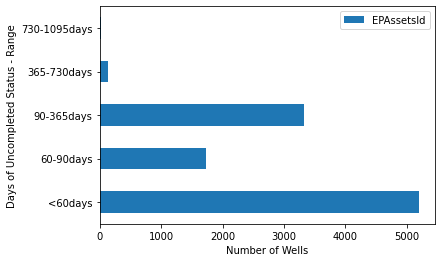

In [ ]:
# create bar graph

non_DUCS_dataframe_binned.plot.barh(x='Binned', y='EPAssetsId')
plt.xlabel('Number of Wells')
plt.ylabel('Days of Uncompleted Status - Range')
plt.show()

## Derive some insights using the bins created for DUC status duration 

In [ ]:
# groupby number of wells by formation and bin labels
non_DUCS_dataframe_binned_formation = non_DUCS_final_dataframe.groupby(['Binned', 'Formation'], as_index=False, observed=True).agg({'EPAssetsId': 'size'})
print(non_DUCS_dataframe_binned_formation)

          Binned Formation  EPAssetsId
0        <60days   Montney         510
1        <60days  Duvernay          47
2        <60days   Cardium         716
3        <60days    Viking        3918
4      60-90days   Montney         607
5      60-90days  Duvernay          90
6      60-90days   Cardium         262
7      60-90days    Viking         779
8     90-365days   Montney        2131
9     90-365days  Duvernay         530
10    90-365days   Cardium         160
11    90-365days    Viking         506
12   365-730days   Montney         102
13   365-730days  Duvernay          17
14   365-730days   Cardium           5
15   365-730days    Viking           4
16  730-1095days   Montney          20
17  730-1095days  Duvernay           1
18  730-1095days   Cardium           1


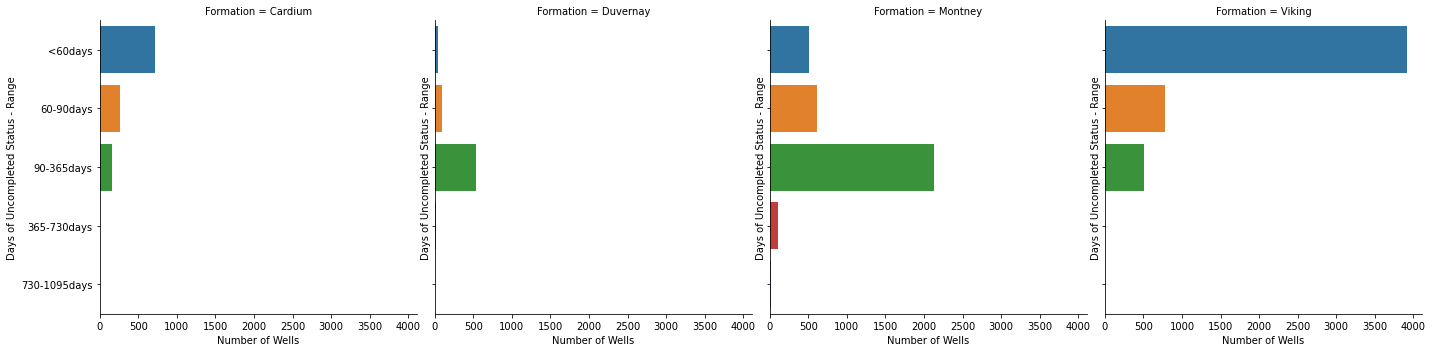

In [ ]:
# Number of wells binned by Days of Uncompleted Status duration by Formation 
g=sns.catplot(x='EPAssetsId', y='Binned', data=non_DUCS_dataframe_binned_formation, col='Formation', kind='bar', height=5, aspect = 1, sharey='row', )
g.set(xlabel='Number of Wells', ylabel= 'Days of Uncompleted Status - Range')
plt.show()

In [ ]:
# groupby number of wells by CurrentStatus and bin labels
non_DUCS_dataframe_binned_CurrentStatus = non_DUCS_final_dataframe.groupby(['Binned', 'CurrentStatus'], as_index=False, observed=True).agg({'EPAssetsId': 'size'})
print(non_DUCS_dataframe_binned_CurrentStatus)

          Binned CurrentStatus  EPAssetsId
0        <60days      Gas Lift          41
1        <60days       Flowing         479
2        <60days     Suspended          36
3        <60days       Pumping        1310
4        <60days        Active        3325
5      60-90days      Gas Lift          30
6      60-90days       Flowing         293
7      60-90days     Suspended          10
8      60-90days       Pumping         584
9      60-90days        Active         821
10    90-365days      Gas Lift          83
11    90-365days       Flowing         626
12    90-365days     Suspended          24
13    90-365days       Pumping        1021
14    90-365days        Active        1573
15   365-730days      Gas Lift           3
16   365-730days       Flowing          34
17   365-730days     Suspended           3
18   365-730days       Pumping          23
19   365-730days        Active          65
20  730-1095days       Flowing           3
21  730-1095days       Pumping           3
22  730-109

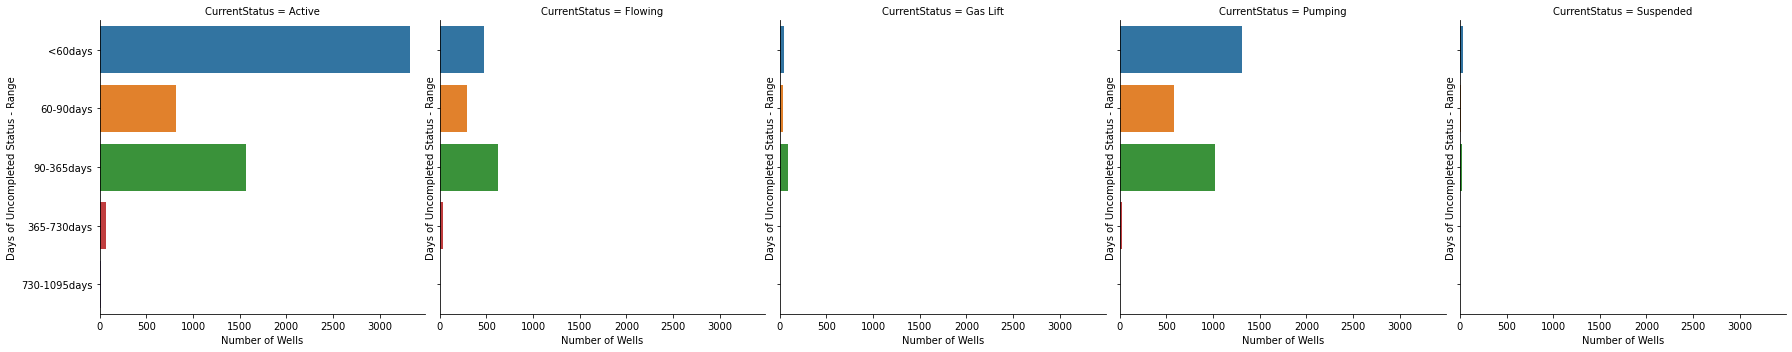

In [ ]:
# Number of wells binned by Days of Uncompleted Status duration by CurrentStatus
g=sns.catplot(x='EPAssetsId', y='Binned', data=non_DUCS_dataframe_binned_CurrentStatus, col='CurrentStatus', kind='bar', height=5, aspect = 1, sharey='row', )
g.set(xlabel='Number of Wells', ylabel= 'Days of Uncompleted Status - Range')
plt.show()

In [ ]:
# groupby number of wells by PSACArea and bin labels
non_DUCS_dataframe_binned_PSACArea = non_DUCS_final_dataframe.groupby(['Binned', 'PSACAreaName'], as_index=False, observed=True).agg({'EPAssetsId': 'size'})
print(non_DUCS_dataframe_binned_PSACArea)

          Binned               PSACAreaName  EPAssetsId
0        <60days            Foothills Front         821
1        <60days            Central Alberta         215
2        <60days       Northwestern Alberta         131
3        <60days       Southeastern Alberta         422
4        <60days       East Central Alberta         265
5        <60days  Southwestern Saskatchewan        3182
6        <60days  Northern British Columbia         155
7      60-90days            Foothills Front         468
8      60-90days            Central Alberta         121
9      60-90days       Northwestern Alberta         135
10     60-90days       Southeastern Alberta         116
11     60-90days                  Foothills           1
12     60-90days       East Central Alberta          71
13     60-90days  Southwestern Saskatchewan         540
14     60-90days  Northern British Columbia         282
15     60-90days     Other British Columbia           4
16    90-365days            Foothills Front     

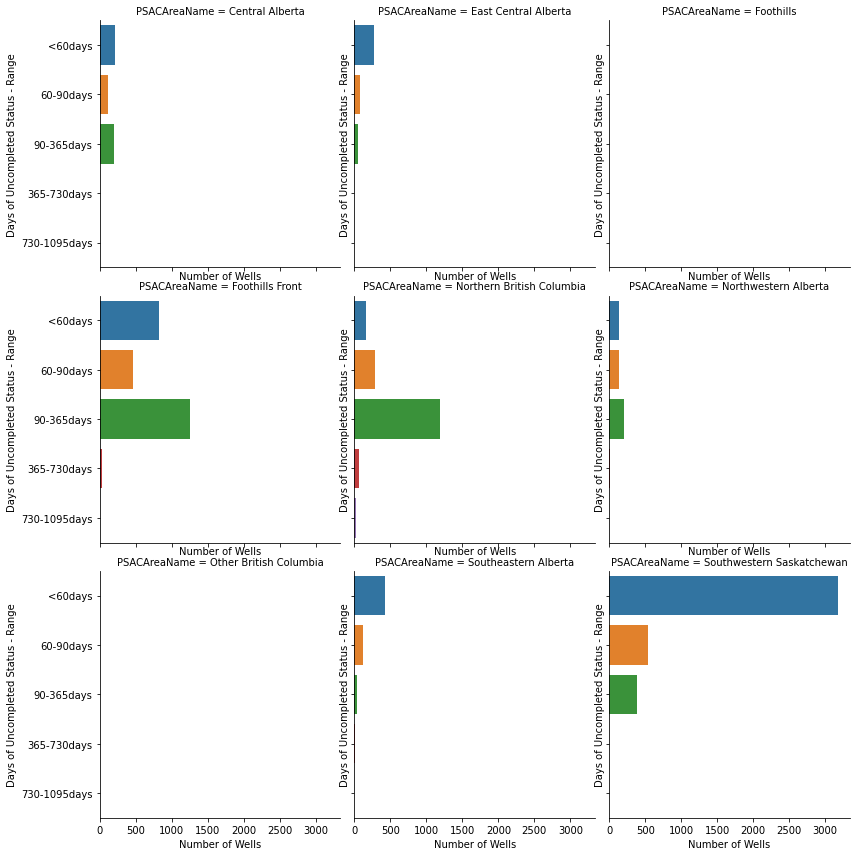

In [ ]:
# Number of wells binned by Days of Uncompleted Status duration by PSACArea
g=sns.catplot(x='EPAssetsId', y='Binned', data=non_DUCS_dataframe_binned_PSACArea, col='PSACAreaName', col_wrap=3, kind='bar', height=4, aspect =1, sharey='row', )
g.set(xlabel='Number of Wells', ylabel= 'Days of Uncompleted Status - Range')
plt.show()

## Additional DUC wells Insights

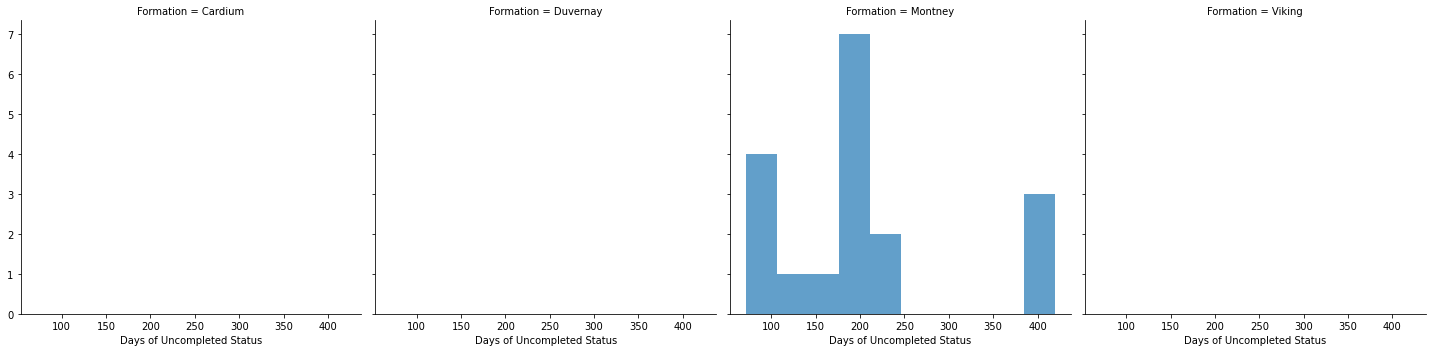

In [ ]:
# Days of Uncompleted Status hist by Formation 
g=sns.FacetGrid(DUCS_final_dataframe, col='Formation', height=5, aspect = 1)
g.map(plt.hist, 'Days of Uncompleted Status', alpha=0.7)
plt.show()

In [ ]:
# Average Days of Uncompleted Status and Number of DUC wells by Field

DUCS_by_field = DUCS_final_dataframe.groupby(by=['Field', 'Province'], as_index=False, observed=True).agg({'Days of Uncompleted Status' : 'mean', 'EPAssetsId': 'size'})

DUCS_by_field.head()



,Field,Province,Days of Uncompleted Status,EPAssetsId
0,Inga,British Columbia,72.00,1
1,Northern Montney,British Columbia,299.20,5
2,Heritage,British Columbia,168.75,12


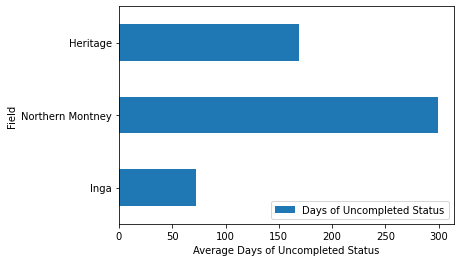

In [ ]:
# Average Days of Uncompleted Status by field
DUCS_by_field.plot.barh(x='Field', y='Days of Uncompleted Status')
plt.xlabel('Average Days of Uncompleted Status')
plt.show()

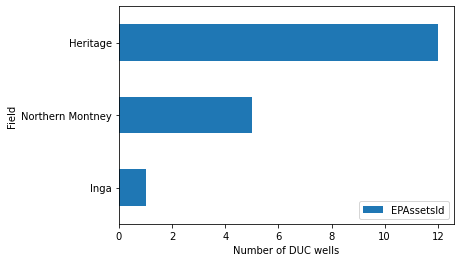

In [ ]:
# Number of DUC wells by Field
DUCS_by_field.plot.barh(x='Field', y='EPAssetsId')
plt.xlabel('Number of DUC wells')
plt.show()

In [ ]:
# Average Days of Uncompleted Status and Number of DUC wells by CurrentOperator

DUCS_by_operator = DUCS_final_dataframe.groupby(by='CurrentOperator', as_index=False, observed=True).agg({'Days of Uncompleted Status' : 'mean', 'EPAssetsId': 'size'})

DUCS_by_operator.head(8)

,CurrentOperator,Days of Uncompleted Status,EPAssetsId
0,Kelt Exploration (Lng) Ltd.,89.500000,2
1,Tourmaline Oil Corp.,195.500000,2
2,Arc Resources Ltd.,199.000000,7
3,Ovintiv Canada Ulc,80.333333,3
4,Storm Resources Ltd.,404.000000,3
5,Saguaro Resources Ltd.,177.000000,1


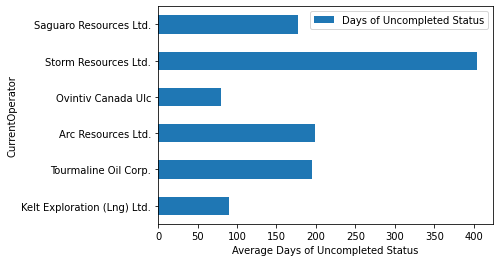

In [ ]:
# Average days of uncompleted status by Operator plot
DUCS_by_operator.plot.barh(x='CurrentOperator', y='Days of Uncompleted Status')
plt.xlabel('Average Days of Uncompleted Status')
plt.show()


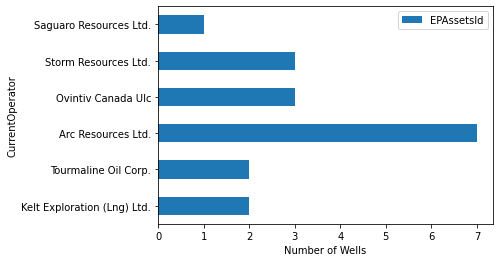

In [ ]:
# Number of wells by Operator plot
DUCS_by_operator.plot.barh(x='CurrentOperator', y='EPAssetsId')
plt.xlabel('Number of Wells')
plt.show()

In [ ]:
# DUC wells by PSACAreaName
DUCS_by_PSACAreaName = DUCS_final_dataframe.groupby(by='PSACAreaName', as_index=False, observed=True).agg({'Days of Uncompleted Status' : 'mean', 'EPAssetsId': 'size'})

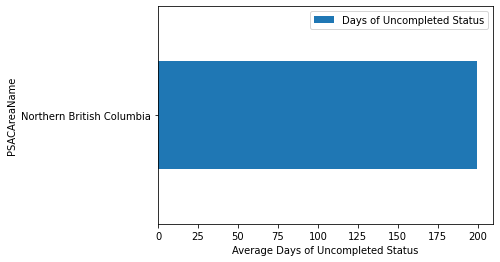

In [ ]:
DUCS_by_PSACAreaName.plot.barh(x='PSACAreaName', y='Days of Uncompleted Status')
plt.xlabel('Average Days of Uncompleted Status')
plt.show()